In [1]:
%pip install dotwiz
%pip install seaborn
%cd ..
%pip install .

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
/home/code


/opt/conda/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Defaulting to user installation because normal site-packages is not writeable
Processing /home/code
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for poseidon: filename=poseidon-0.2.0-py3-none-any.whl size=28890 sha256=8747f4f1cf7d68a4b8b90381443778bc16459c0fdfad9f597f5020a0d5125b8d
  Stored in directory: /tmp/pip-ephem-wheel-cache-utcqmdwj/wheels/66/a1/6f/7bf00096e99bf76d1238d9a3b870def62537c6737d07a01b3d
Successfully built poseidon
  Attempting uninstall: poseidon
    Found existing installation: poseidon 0.2.0
    Uninstalling poseidon-0.2.0:
      Successfully uninstalled poseidon-0.2.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from dotwiz import DotWiz
from pathlib import Path

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader

from poseidon.io.iara.offline import load_sonar_from_csv, Target, load_processed_data
from poseidon.dataset.dataset import SonarRunDataset, SonarRunPairDataset
from poseidon.model_selection import SonarCrossValidator
from poseidon.signal_poseidon.passivesonar import lofar
from poseidon.signal_poseidon.utils import resample

from poseidon.visualization import plot_lofargram
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [3]:
config =  {
    "dataset": {
        "name": "iara",
        "metadata_path": "../data/iara.csv",
        "raw_data_path" : "/home/iara/",
        "cache_path" : "./data/iara_cache"
    },
    # "window_size": 1,
    "window_size": 16,
    "overlap" : 0,
    "n_freqs": 512,
    "learning_rate": 0.001,
    "model_name": "MLP",
    "output_size": 4,
    "batch_size": 32,
    "hidden_size": 128,
    "n_splits": 5,
    "fold": 0,
    "epochs": 100,
    "patience": 10,
    "seed": 42,
    "dc_filter": ['D', 'H']
    
}
config = DotWiz(config)

In [10]:
%ls ../data

iara.csv*


In [4]:
csv_path = config.dataset.metadata_path
iara_data_root_path = config.dataset.raw_data_path
iara_raw = load_sonar_from_csv(csv_path, data_root_path=iara_data_root_path, target_column="Ship Length Class", data_collection_filter=config.dc_filter)

Reading dataset metadata from: ../data/iara.csv
Using data root path: /home/iara/
Grouping by target column: 'Ship Length Class'
Dataset structure loaded. Found 4 classes.
  - Class '0': 169 runs
  - Class '1': 129 runs
  - Class '2': 151 runs
  - Class '3': 47 runs


In [ ]:
# iara_raw['0']['A-0002']['fs']

cache_dir = config.dataset.cache_path
Path(cache_dir).mkdir(parents=True, exist_ok=True)

def lofar_fn(x):
    signal = resample(x['signal'], x['fs'], 16000)
    fs = 16000
    # x is a dict with keys 'signal' and 'fs'
    # x['signal'] is the audio signal, x['fs'] is the sampling frequency
    lofar_value = lofar(signal, fs, n_pts_fft=1024, n_overlap=0,
                  spectrum_bins_left=512)
    power = lofar_value['sxx']
    freq = lofar_value['freq']
    time = lofar_value['time']
    
    delta_t = time[-1] - time[-2]
    
    integration_interval = 0.512
    integration_overlap = 0
    
    n_means = int(np.round(integration_interval / delta_t))
    n_overlap = int(np.round((integration_interval-integration_overlap)/ delta_t))

    final_power = []
    final_times = []

    for i in range(0, len(time), n_overlap):
        mean_spectrum = np.mean(power[:, i:i+n_means], axis=1)
        final_power.append(mean_spectrum)
        final_times.append(time[i])
        
    return {'sxx': np.transpose(final_power), 'freq': freq, 'time':final_times}


iara_raw.process_and_cache(fn=lofar_fn, max_workers=8, cache_path=cache_dir)

Starting PARALLEL processing with 8 workers.
Found 496 files to process. 0 files are already cached.
bateu na _process_single_file
bateu na _process_single_file
bateu na _process_single_file
bateu na _process_single_file
bateu na _process_single_file
bateu na _process_single_file
bateu na _process_single_file
bateu na _process_single_file


Processing runs:   0%|                                                                      | 0/496 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Processing runs:   0%|▏                                                             | 1/496 [00:06<57:10,  6.93s/it]

bateu na _process_single_file


Processing runs:   1%|▍                                                             | 3/496 [00:07<15:22,  1.87s/it]

bateu na _process_single_file
bateu na _process_single_file


Processing runs:   1%|▌                                                             | 4/496 [00:08<10:14,  1.25s/it]

bateu na _process_single_file
bateu na _process_single_file


Processing runs:   2%|█                                                             | 8/496 [00:08<02:48,  2.89it/s]

bateu na _process_single_file
bateu na _process_single_file
bateu na _process_single_file


Processing runs:   2%|█▏                                                            | 9/496 [00:09<02:52,  2.83it/s]

bateu na _process_single_file


Processing runs:   2%|█▏                                                           | 10/496 [00:09<04:00,  2.02it/s]

bateu na _process_single_file


Processing runs:   2%|█▎                                                           | 11/496 [00:12<08:39,  1.07s/it]

bateu na _process_single_file


Processing runs:   2%|█▍                                                           | 12/496 [00:13<08:23,  1.04s/it]

bateu na _process_single_file


Processing runs:   3%|█▋                                                           | 14/496 [00:14<06:41,  1.20it/s]

bateu na _process_single_file
bateu na _process_single_file


Processing runs:   3%|█▉                                                           | 16/496 [00:15<04:08,  1.93it/s]

bateu na _process_single_file
bateu na _process_single_file


Processing runs:   4%|██▏                                                          | 18/496 [00:15<02:32,  3.13it/s]

bateu na _process_single_file
bateu na _process_single_file


Processing runs:   4%|██▎                                                          | 19/496 [00:15<02:12,  3.60it/s]

bateu na _process_single_file


In [22]:
iara_spectrogram = load_processed_data(cache_dir)
iara_spectrogram

Loading processed data structure from: ./data/iara_cache
Processed dataset structure loaded. Found 4 classes.
  - Class '3': 47 runs
  - Class '2': 151 runs
  - Class '1': 129 runs
  - Class '0': 169 runs


{'3': {'H-1782': <LazySpectrogramRecord(file='H-1782.npz', status='Not Loaded (on disk)')>,
  'H-1779': <LazySpectrogramRecord(file='H-1779.npz', status='Not Loaded (on disk)')>,
  'H-1822': <LazySpectrogramRecord(file='H-1822.npz', status='Not Loaded (on disk)')>,
  'H-1818': <LazySpectrogramRecord(file='H-1818.npz', status='Not Loaded (on disk)')>,
  'H-1824': <LazySpectrogramRecord(file='H-1824.npz', status='Not Loaded (on disk)')>,
  'H-1788': <LazySpectrogramRecord(file='H-1788.npz', status='Not Loaded (on disk)')>,
  'H-1784': <LazySpectrogramRecord(file='H-1784.npz', status='Not Loaded (on disk)')>,
  'H-1789': <LazySpectrogramRecord(file='H-1789.npz', status='Not Loaded (on disk)')>,
  'H-1798': <LazySpectrogramRecord(file='H-1798.npz', status='Not Loaded (on disk)')>,
  'H-1794': <LazySpectrogramRecord(file='H-1794.npz', status='Not Loaded (on disk)')>,
  'H-1805': <LazySpectrogramRecord(file='H-1805.npz', status='Not Loaded (on disk)')>,
  'H-1796': <LazySpectrogramRecord(fil

In [48]:
class_map = {
    '0': "Small",
    '1': "Medium",
    '2': "Large",
    '3': "Background",
}

# CORREÇÃO: Usamos int(cls_name) diretamente
trgt = np.concatenate([
    int(cls_name) * np.ones(run_item['sxx'].shape[0])
    for cls_name, run in iara_spectrogram.items()
    for run_name, run_item in run.items()
])

# Esta parte não precisa de alterações, pois não usa o class_map.
data = np.concatenate([
    run_item['sxx']
    for cls_name, run in iara_spectrogram.items()
    for run_name, run_item in run.items()
], axis=0)

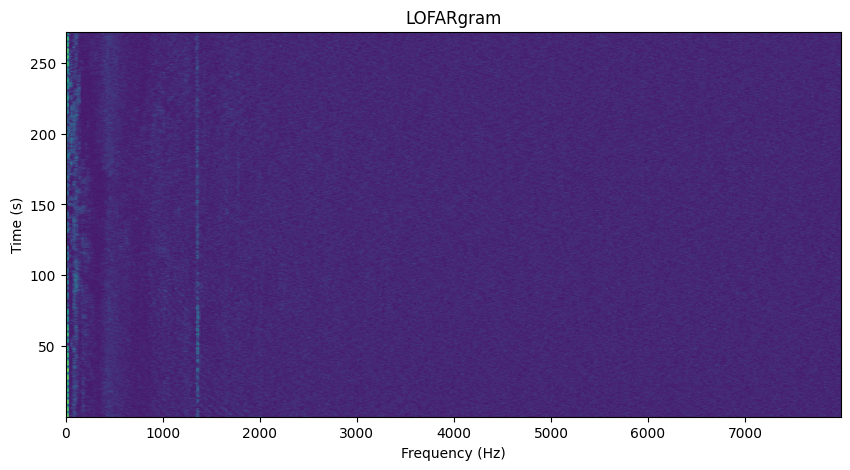

In [24]:
cls = '1'
run = 'D-1313'

sxx =  iara_spectrogram[cls][run]['sxx']
freq = iara_spectrogram[cls][run]['freq']
time = iara_spectrogram[cls][run]['time']

from poseidon.visualization import plot_lofargram
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
plot_lofargram(sxx, freq, time, ax=ax)
plt.show()

In [30]:
metadata_df = pd.read_csv(csv_path)
metadata_df['Length'] = metadata_df['Length'].apply(lambda x: np.nan if x == ' - ' else float(x))
metadata_df['Ship Length Class'] = metadata_df['Length'].apply(Target.classify_value)
metadata_df = metadata_df[metadata_df['Dataset'].isin(['D', 'H'])]
metadata_df.reset_index(drop=True, inplace=True)
metadata_df

cross_validator = SonarCrossValidator(
    metadata_df=metadata_df,
    target_column='Ship Length Class',
    stratify_columns=['Ship Length Class'],
    n_splits=config.n_splits,
    random_state=config.seed
)

train_data, test_data = cross_validator.get_fold_data(config.fold, cache_dir)

Creating 5 stratified splits based on columns: ['Ship Length Class']
Created class mapping: {0: 0, 1: 1, 2: 2, 3: 3}


In [31]:
is2d = config.window_size != 1

train_dataset = SonarRunDataset(train_data, window_size=config.window_size, overlap=config.overlap, is2d=is2d)
test_dataset = SonarRunDataset(test_data, window_size=config.window_size, overlap=config.overlap, is2d=is2d)

Building window map for SonarRunDataset...
Map built. Total windows available: 101885
Building window map for SonarRunDataset...
Map built. Total windows available: 26093


In [ ]:
from poseidon.utils import calculate_class_weights

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_dataset = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
test_dataset = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

class_weights = calculate_class_weights(train_dataset, device)

input_size = (config.window_size, config.n_freqs)
model_cl = model_select(config)
raise NotImplementedError("Model training not implemented yet.")